In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wrangle as acq
import seaborn as sns
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from pydataset import data
from sklearn.linear_model import LassoLars
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor



In [2]:
df = data('tips')
df.head()
df = df.dropna()
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
#df = acq.prep_tips(df)

In [4]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
df['price_per_person'] = (df['total_bill'] + df['tip'] / df['size'])
df['sex'] = df['sex'].replace({'Male': '0', 'Female': '1',})
df['smoker'] = df['smoker'].replace({'Yes': '1', 'No': '0'})
df['day'] = df['day'].replace({'Sun': '1', 'Mon': '2', 'Tue': '3', 'Wed': '4', 'Thur': '5', 'Fri': '6', 'Sat': '7'})
df['time'] = df['time'].replace({'Lunch': '1', 'Dinner': '2'})

In [6]:
X, Y = acq.split_tips_data(df)

# splitting data into train, validate, and test
X_train, X_validate, X_test, y_train, y_validate, y_test = acq.train_validate_test_split(X, Y)


X_train = pd.DataFrame(X_train)
X_validate = pd.DataFrame(X_validate)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)


    X_train -> (136, 7)'
    X_validate -> (59, 7)'
    X_test -> (49, 7)


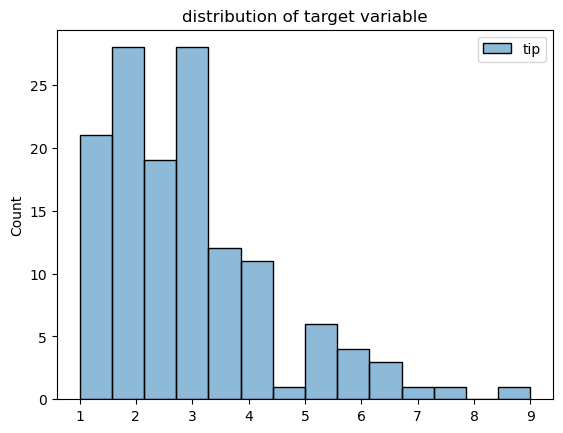

In [7]:
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

In [8]:
baseline = y_train.mean()
baseline

tip    2.946985
dtype: float64

In [9]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2


In [10]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(y_train))
baseline_array[:5]


tip    2.946985
tip    2.946985
tip    2.946985
tip    2.946985
tip    2.946985
dtype: float64

In [11]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2


(1.4512460770849047, 0.0)

In [12]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df


,model,rmse,r2
0,baseline,1.451246,0.0


OLS

In [13]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

In [14]:
print('selected top feature:', rfe.get_feature_names_out())


selected top feature: ['price_per_person']


In [15]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [16]:
pred_lr1[:10]

array([[2.73287696],
       [1.77013542],
       [2.17612007],
       [3.39465318],
       [4.50256851],
       [5.20507833],
       [3.50411267],
       [3.16820525],
       [2.80160285],
       [3.22380372]])

In [17]:
metrics_reg(y_train, pred_lr1)

(1.0254307465510644, 0.5007356540479637)

In [18]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(1.0308410229652665, 0.5259436889531441)

In [19]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,1.451246,0.000000
1,ols_1,1.030841,0.525944


In [20]:
lr1.intercept_


array([0.63210426])

In [21]:
lr1.coef_


array([[0.11583014]])

In [22]:
#print(f'tip = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*total_bill')


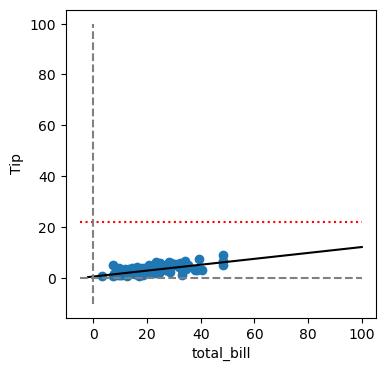

In [23]:
plt.figure(figsize=(4, 4))

plt.scatter(X_train.total_bill, y_train.tip)

#build prediction line from intercept and slope
x_val = np.array([-2, 100]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

#intercept line
plt.hlines(22, -5, 100, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 100, ls='--', color='grey')
plt.vlines(0, -10, 100, ls='--', color='grey')
 
plt.xlabel('total_bill')
plt.ylabel('Tip')
plt.show()

In [24]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(X_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(X_train)

#use it on validate
pred_val_lr2 = lr2.predict(X_validate)

In [25]:
pred_lr2[:10]

array([[3.31958592],
       [5.33507253],
       [1.65199757],
       [4.79498887],
       [1.19190009],
       [3.55228032],
       [5.27683532],
       [3.3463512 ],
       [2.63600841],
       [3.66296814]])

In [26]:
metrics_reg(y_train, pred_lr2)


(0.3682207635607762, 0.935622452064365)

In [27]:
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(0.3546704242773415, 0.9438827351898619)

In [28]:
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,1.451246,0.000000
1,ols_1,1.030841,0.525944
2,ols,0.354670,0.943883


In [29]:
#make it
lars = LassoLars(alpha=0)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)

In [30]:
pd.Series(lars.coef_, index=lars.feature_names_in_)


total_bill         -2.306693
sex                -0.005515
smoker             -0.157825
day                 0.006821
time                0.059314
size                0.937668
price_per_person    2.323913
dtype: float64

In [31]:
lr2.coef_


array([[-2.30669264, -0.00551506, -0.15782491,  0.00682068,  0.05931378,
         0.93766806,  2.32391273]])

In [32]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_validate)

In [33]:
metrics_reg(y_train, pred_lars)


(1.4512460770849047, 0.0)

In [34]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2


(1.5173853468530591, -0.02716051848516643)

In [35]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [36]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [37]:
metrics_reg(y_train, pred_pr)


(2.9968371276173e-14, 1.0)

In [38]:
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(1.5173853468530591, -0.02716051848516643)

In [39]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,1.451246,0.000000
1,ols_1,1.030841,0.525944
2,ols,0.354670,0.943883
3,lars,1.517385,-0.027161


In [40]:
glm = TweedieRegressor(power=1, alpha=0)

#fit it
glm.fit(X_train, y_train)

#use it
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_validate)

In [41]:
metrics_reg(y_train, pred_glm)


(0.33652965993994033, 0.9462269617083772)

In [42]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2


(0.8450784511184269, 0.681403792699891)

In [43]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,1.451246,0.000000
1,ols_1,1.030841,0.525944
2,ols,0.354670,0.943883
3,lars,1.517385,-0.027161
5,glm,0.845078,0.681404


In [44]:
pred_test = pr.predict(X_test_degree2)
pred_test


array([[4.  ],
       [3.35],
       [2.  ],
       [2.  ],
       [2.5 ],
       [3.09],
       [3.  ],
       [3.4 ],
       [3.  ],
       [3.18],
       [1.56],
       [1.5 ],
       [3.  ],
       [2.5 ],
       [3.06],
       [3.5 ],
       [2.  ],
       [3.  ],
       [3.5 ],
       [4.08],
       [4.  ],
       [2.02],
       [2.31],
       [2.  ],
       [2.  ],
       [3.  ],
       [5.  ],
       [5.2 ],
       [2.71],
       [2.  ],
       [3.18],
       [2.  ],
       [2.  ],
       [3.07],
       [2.45],
       [1.5 ],
       [2.  ],
       [4.71],
       [3.61],
       [2.  ],
       [4.  ],
       [3.  ],
       [2.75],
       [2.3 ],
       [4.73],
       [4.29],
       [1.98],
       [3.5 ],
       [1.83]])

In [45]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(4.011774188400689e-14, 1.0)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

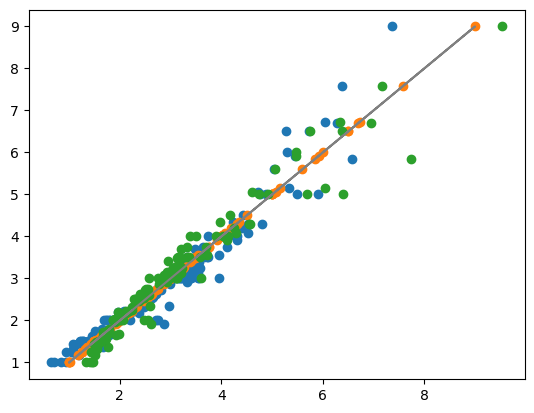

In [46]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Tip")
plt.xlabel("Predicted Tip")
plt.legend()

plt.show()

ValueError: Unable to coerce to Series, length must be 1: given 136

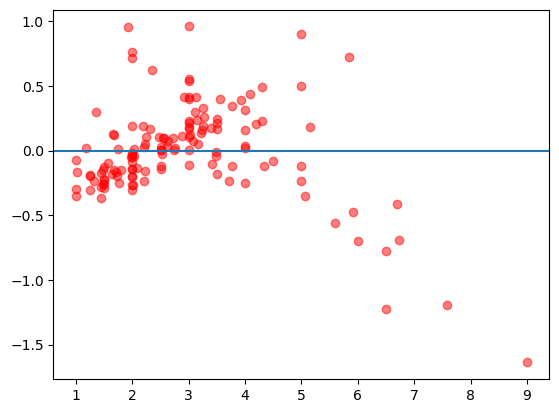

In [47]:
plt.axhline(label="No Error")

plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color="red", label="LinearRegression")
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

plt.legend()
plt.title("Do the size of errors change as the actual value changes?")
plt.xlabel("Actual Tip")
plt.ylabel("Residual: Predicted Tip - Actual Tip")

plt.show()

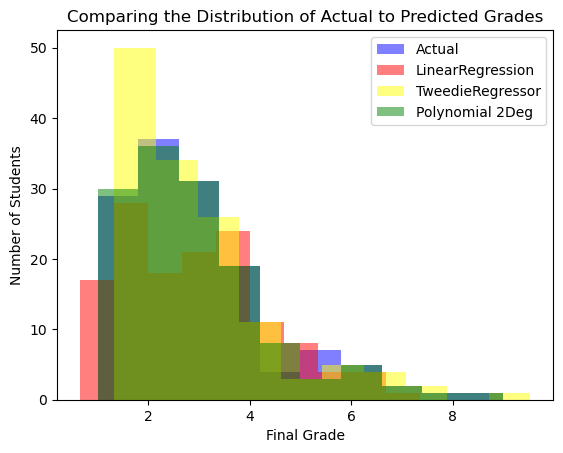

In [48]:
plt.hist(y_train, color='blue', alpha=.5, label="Actual")
plt.hist(pred_lr2, color='red', alpha=.5, label="LinearRegression")
plt.hist(pred_glm, color='yellow', alpha=.5, label="TweedieRegressor")
plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")

plt.xlabel("Final Grade")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual to Predicted Grades")
plt.legend()
plt.show()

In [ ]:
# Fix prep file, solve the dummy problem, and redo. 